# Preprocessing Cheat Sheet
```PSMCV-2.2022-2023.1```

Author: Robbert van der Mijn, w.r.van.der.mijn@rug.nl, 2022

Here you'll find just the scripts that are useful during preprocessing

## Modules and Packages

In [1]:
from datamatrix import (
    plot,
    operations as ops,
    series as srs,
    functional as fnc,
    SeriesColumn,
)
from eyelinkparser import parse, defaulttraceprocessor
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager

## Declaring a function

In [7]:
@fnc.memoize(persistent=True)
def my_preprocessor():
    
    dm = parse(
        traceprocessor = defaulttraceprocessor(
          blinkreconstruct = False, 
          downsample = None
        )
    )
    
    # define the max depth manually: baseline, problem, fixation, response and feedback
    MAX_DEPTH = 1500 + 800 + 2500 + 2000 

    # get the current max depth, we'll be cutting it off later
    max_depth = dm.ptrace_baseline.depth + dm.ptrace_problem.depth + dm.ptrace_fixation.depth + dm.ptrace_response.depth + dm.ptrace_feedback.depth

    # Create new series column that will hold our new pupil trace
    dm.pupil = SeriesColumn(depth = max_depth)

    # For each trial, trim pupil traces based on the nan values in the time trace (there are more elegant solutions I'm sure)
    for i, row in enumerate(dm):
        ptrace_baseline = row.ptrace_baseline[~np.isnan(row.ttrace_baseline)]
        ptrace_problem = row.ptrace_problem[~np.isnan(row.ttrace_problem)]
        ptrace_fixation = row.ptrace_fixation[~np.isnan(row.ttrace_fixation)]
        ptrace_response = row.ptrace_response[~np.isnan(row.ttrace_response)]
        ptrace_feedback = row.ptrace_feedback[~np.isnan(row.ttrace_feedback)]
        
        # Concatenate and pad so they're all the same depth
        pupil = np.concatenate((ptrace_baseline, ptrace_problem, ptrace_fixation, ptrace_response, ptrace_feedback))
        pupil = np.pad(pupil, (0, max_depth - len(pupil)), "constant", constant_values = np.nan)
        
        # Write this trial to the original dm
        dm.pupil[i] = pupil
        
    # Trim the original dm to our manual depth (the feedback phase of some of the really long trials will be cut off)
    dm.pupil.depth = MAX_DEPTH
    
    dm = dm[("subject_nr", "pupil", "count_trial_sequence", "correct", "difficulty", "practice")]
    
    return dm

# my_preprocessor.clear() # you can run this line to clear the stored output of the function
dm = my_preprocessor()

## Saving plots as pngs

(300.0, 2700.0)

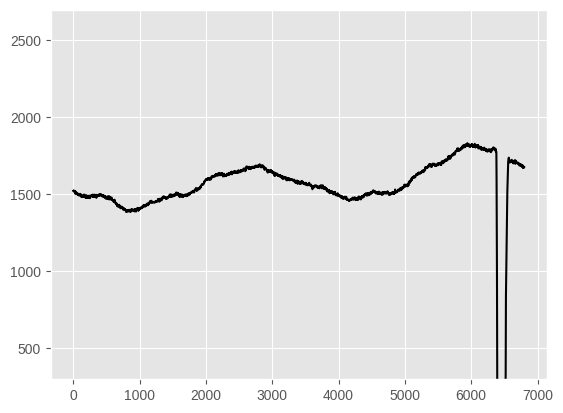

In [3]:
plt.plot(dm.pupil[0], color = "black")
plt.ylim(300, 2700)
plt.savefig('single_trial.png', bbox_inches='tight')

plt.figure()
for row in dm:    
    plt.plot(row.pupil, alpha = .1, color = "black")
plt.ylim(300, 2700)
plt.savefig('all_trials.png', bbox_inches='tight')

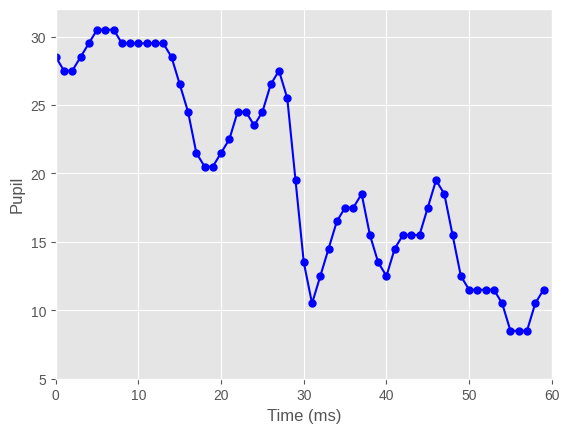

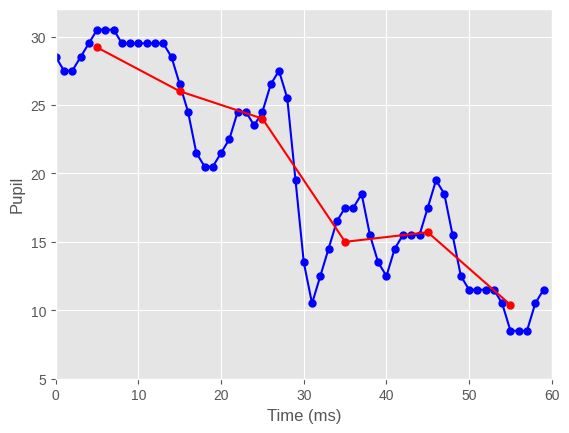

In [23]:
dm.pupil_reconstructed = srs.blinkreconstruct(dm.pupil, mode = "advanced")
dm.pupil_baselined = srs.baseline(dm.pupil_reconstructed, dm.pupil_reconstructed, bl_start = 1480, bl_end = 1500)

DS = 10
DUR = 300
SAMPDUR = 1
pupil = dm.pupil_baselined[0, :DUR]
time = np.arange(DUR)
pupil_ds = srs.downsample(dm.pupil_baselined[0, :DUR], DS)
time_ds = np.arange((DS * SAMPDUR)/2, DUR, step = DS * SAMPDUR) # a new time vector must also be created

ZOOM_IN = 60
plt.figure()
plt.plot(time[:ZOOM_IN], pupil[:ZOOM_IN], "-", color = "blue")
plt.plot(time[:ZOOM_IN], pupil[:ZOOM_IN], ".", color = "blue", ms = 10)
plt.ylim(5, 32)
plt.xlim(0, 60)
plt.xlabel("Time (ms)")
plt.ylabel("Pupil")
plt.savefig('ds1.png', bbox_inches='tight')

plt.figure()
plt.plot(time[:ZOOM_IN], pupil[:ZOOM_IN], "-", color = "blue")
plt.plot(time[:ZOOM_IN], pupil[:ZOOM_IN], ".", color = "blue", ms = 10)
plt.plot(time_ds[:int(ZOOM_IN/DS)], pupil_ds[:int(ZOOM_IN/DS)], "-", color = "red")
plt.plot(time_ds[:int(ZOOM_IN/DS)], pupil_ds[:int(ZOOM_IN/DS)], ".", color = "red", ms = 10)
plt.ylim(5, 32)
plt.xlim(0, 60)
plt.xlabel("Time (ms)")
plt.ylabel("Pupil")
plt.savefig('ds2.png', bbox_inches='tight')

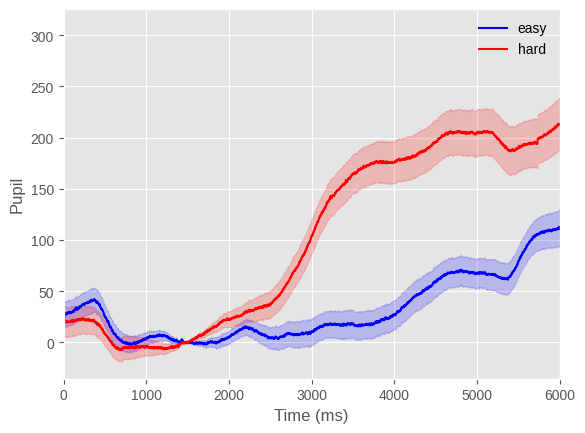

In [27]:
CON_COLS = {"easy": "blue", "hard": "red"}
plt.figure()
for c, cdm in ops.split(dm.difficulty):
    plot.trace(cdm.pupil_baselined, color = CON_COLS[c], label = c)
plt.xlim(0, 6000)
plt.xlabel("Time (ms)")
plt.ylabel("Pupil")
plt.legend(frameon = False)
plt.savefig('mean.png', bbox_inches='tight')